In [32]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC

import date_transformer
import imputing_transformer
import column_extractor
import categorical_transformer
import cleanup_transformer
import ModelTransformer
import classification_model
import pandas_column_utilities

import pandas as pd
import numpy as np
from datetime import datetime, timedelta

pandas_column_utilities= reload(pandas_column_utilities)


In [12]:
df = pd.read_csv("/Users/predev/Documents/Learn/MachineLearning/Galvanize/Case_Study_21-2/Data/churn_train.csv")

In [16]:
pandas_column_utilities.info(df)

,Count,,Type,Possible Values,Few Values
Column,,,,,
avg_dist,40000,non-null,float64,,"[6.94, 8.06, 21.5, 9.46, 13.77, 14.51, 4.87, 1..."
avg_rating_by_driver,39838,non-null,float64,,"[5.0, 4.0, 4.7, 4.8, 4.3, 4.6, 4.9, 4.4, 3.0, ..."
avg_rating_of_driver,33472,non-null,float64,,"[5.0, nan, 4.0, 4.7, 3.0, 3.7, 4.5, 3.3, 3.6, ..."
avg_surge,40000,non-null,float64,,"[1.0, 2.75, 2.0, 1.15, 1.02, 1.11, 1.2, 1.03, ..."
city,40000,non-null,object,,"[Astapor, Winterfell, King's Landing]"
last_trip_date,40000,non-null,object,{DATE},"[2014-05-03, 2014-01-26, 2014-05-21, 2014-01-1..."
phone,39681,non-null,object,,"[Android, iPhone, nan]"
signup_date,40000,non-null,object,{DATE},"[2014-01-12, 2014-01-25, 2014-01-02, 2014-01-0..."
surge_pct,40000,non-null,float64,,"[0.0, 100.0, 20.0, 9.1, 2.6, 14.3, 28.6, 11.1,..."


None


In [44]:
ordinal = {'luxury_car_user':{False:0,True:1}}
categorical = ['city','phone']
date_manip = ['signup_date']
cont = ['avg_dist','avg_rating_by_driver','avg_rating_of_driver','avg_surge','surge_pct','trips_in_first_30_days','weekday_pct']

#last_trip_date = leakage?
#active imbalanced class? No
#outliers miles
#rating categories
#user - signed up on weekday/weekend
date_la = datetime.strptime('2014-07-01','%Y-%m-%d')
df['active'] = df['last_trip_date'].apply(lambda x: 1 if date_la - datetime.strptime(x, '%Y-%m-%d') <= timedelta(days = 30) else 0)

In [23]:
# Scatterplot Matrix
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix



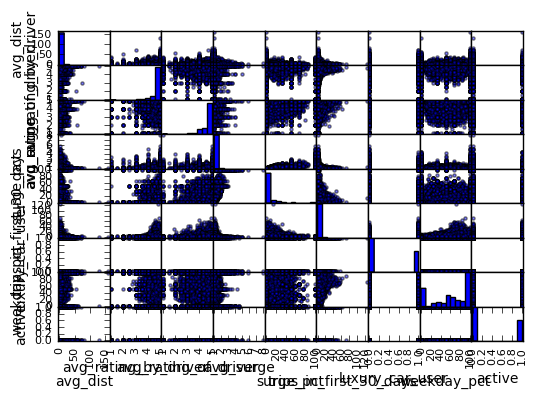

In [35]:
fig = plt.figure(figsize=(400,40))
scatter_matrix(df)
plt.show()

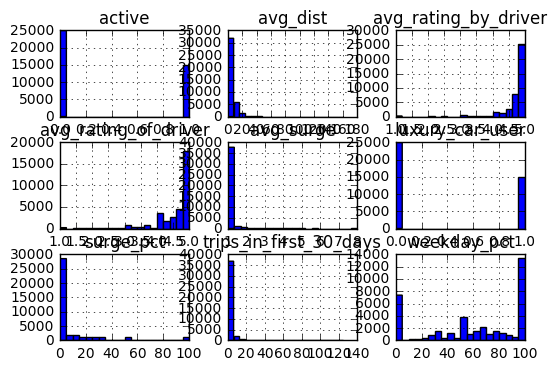

In [39]:
df.hist(bins = 20)
plt.show()

In [45]:
date_pip = Pipeline([('extract',column_extractor.column_extractor(date_manip)),
                ('date_manip', date_transformer.date_transformer('%Y-%m-%d')),
                ('d-m-y-q-dow', FeatureUnion([('day',date_transformer.day_of_month_transformer()),
                                            ('month',date_transformer.month_transformer()),
                                            ('dow',date_transformer.day_of_week_transformer()),
                                            ('quarter',date_transformer.month_quarter_transformer()),
                                            ('year',date_transformer.year_transformer())])),
                ('impute',imputing_transformer.imputing_transformer(Imputer(strategy='most_frequent')))])

continuous = Pipeline([
            ('extract', column_extractor.column_extractor(cont)),
            ('impute',imputing_transformer.imputing_transformer(Imputer(strategy='most_frequent'))),
            ('scale', Normalizer())])

ordinal_pip = Pipeline([('extract', column_extractor.column_extractor(ordinal)),
                        ('ord', categorical_transformer.ordinal_transformer(ordinal)),
                       ('impute',imputing_transformer.imputing_transformer(Imputer(strategy='most_frequent')))])

one_hot = Pipeline([('extract', column_extractor.column_extractor(categorical)),
                    ('lab_enc', categorical_transformer.label_transformer()),
                    ('one_hot', ModelTransformer.ModelTransformer(OneHotEncoder(sparse=False)))])


features = Pipeline([('parallel', FeatureUnion([('date',date_pip),
                                                ('continuous',continuous),
                                                ('ordinal_pip',ordinal_pip),
                                                ('one_hot',one_hot)])),
                    ('cleanup',cleanup_transformer.cleanup_transformer())])

In [46]:
select_features = Pipeline([('feat_imp',FeatureUnion([('xtra_tree', SelectFromModel(ExtraTreesClassifier()))
                                                      ,('lin',SelectFromModel(LinearSVC(penalty="l1", dual=False)))]))])

In [ ]:
avg_dist